# **Electronic structure**

## **Introduction** 

The molecular Hamiltonian is 

$$
\mathcal{H} = - \sum_I \frac{\nabla_{R_I}^2}{M_I} - \sum_i \frac{\nabla_{r_i}^2}{m_e} - \sum_I\sum_i  \frac{Z_I e^2}{|R_I-r_i|} + \sum_i \sum_{j>i} \frac{e^2}{|r_i-r_j|} + \sum_I\sum_{J>I} \frac{Z_I Z_J e^2}{|R_I-R_J|}
$$

Because the nuclei are much heavier than the electrons they do not move on the same time scale and therefore, the behavior of nuclei and electrons can be decoupled. This is the Born-Oppenheimer approximation.

Therefore, one can first tackle the electronic problem with nuclear coordinate entering only as parameters. The energy levels of the electrons in the molecule can be found by solving the non-relativistic time independent Schroedinger equation,

$$
\mathcal{H}_{\text{el}} |\Psi_{n}\rangle = E_{n} |\Psi_{n}\rangle
$$

where 

$$
\mathcal{H}_{\text{el}} = - \sum_i \frac{\nabla_{r_i}^2}{m_e} - \sum_I\sum_i  \frac{Z_I e^2}{|R_I-r_i|} + \sum_i \sum_{j>i} \frac{e^2}{|r_i-r_j|}.
$$

In particular the ground state energy is given by:
$$
E_0 = \frac{\langle \Psi_0 | H_{\text{el}} | \Psi_0 \rangle}{\langle \Psi_0 | \Psi_0 \rangle}
$$
where $\Psi_0$ is the ground state of the system. 

However, the dimensionality of this problem grows exponentially with the number of degrees of freedom. To tackle this issue we would like to prepare $\Psi_0$ on a quantum computer and measure the Hamiltonian expectation value (or $E_0$) directly. 

So how do we do that concretely? 

## **The Hartree-Fock initial state** 

A good starting point for solving this problem is the Hartree-Fock (HF) method. This method approximates a N-body problem into N one-body problems where each electron evolves in the mean-field of the others. Classically solving the HF equations is efficient and leads to the exact exchange energy but does not include any electron correlation. Therefore, it is usually a good starting point to start adding correlation. 

The Hamiltonian can then be re-expressed in the basis of the solutions of the HF method, also called Molecular Orbitals (MOs):

$$
\hat{H}_{elec}=\sum_{pq} h_{pq} \hat{a}^{\dagger}_p \hat{a}_q + 
\frac{1}{2} \sum_{pqrs} h_{pqrs}  \hat{a}^{\dagger}_p \hat{a}^{\dagger}_q \hat{a}_r  \hat{a}_s
$$
with the 1-body integrals
$$
h_{pq} = \int \phi^*_p(r) \left( -\frac{1}{2} \nabla^2 - \sum_{I} \frac{Z_I}{R_I- r} \right)   \phi_q(r)dr
$$
and 2-body integrals
$$
h_{pqrs} = \int \frac{\phi^*_p(r_1)  \phi^*_q(r_2) \phi_r(r_2)  \phi_s(r_1)}{|r_1-r_2|}dr_1dr_2.
$$

The MOs ($\phi_u$) can be occupied or virtual (unoccupied). One MO can contain 2 electrons. However, in what follows we actually work with Spin Orbitals which are associated with a spin up ($\alpha$) of spin down ($\beta$) electron. Thus Spin Orbitals can contain one electron or be unoccupied. 

We now show how to concretely realise these steps with Qiskit.

Qiskit is interfaced with different classical codes which are able to find the HF solutions. Interfacing between Qiskit and the following codes is already available:
* Gaussian
* Psi4
* PyQuante
* PySCF

In the following we set up a PySCF driver, for the hydrogen molecule at equilibrium bond length (0.735 angstrom) in the singlet state and with no charge. 

In [1]:
!pip install qiskit_nature

In [2]:
!pip install pyscf

     |████████████████████████████████| 37.5 MB 264 kB/s 


In [3]:
from qiskit_nature.drivers import UnitsType, Molecule
from qiskit_nature.drivers.second_quantization import (
    ElectronicStructureDriverType,
    ElectronicStructureMoleculeDriver,
)

molecule = Molecule(
    geometry=[["H", [0.0, 0.0, 0.0]], ["H", [0.0, 0.0, 0.735]]], charge=0, multiplicity=1
)
driver = ElectronicStructureMoleculeDriver(
    molecule, basis="sto3g", driver_type=ElectronicStructureDriverType.PYSCF
)

For further information about the drivers see https://qiskit.org/documentation/nature/apidocs/qiskit_nature.drivers.second_quantization.html

## **The mapping from fermions to qubits** 

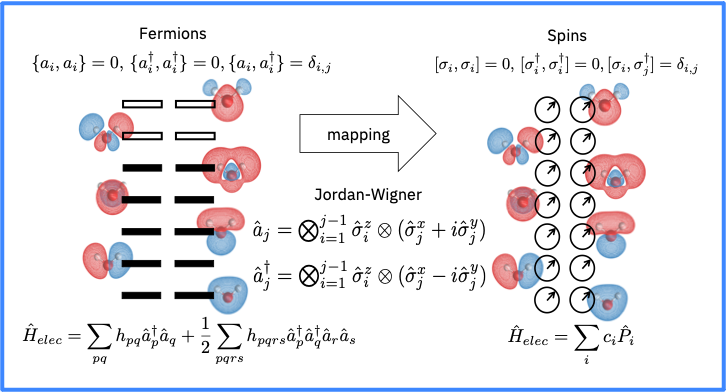

The Hamiltonian given in the previous section is expressed in terms of fermionic operators. To encode the problem into the state of a quantum computer, these operators must be mapped to spin operators (indeed the qubits follow spin statistics). 

There exist different mapping types with different properties. Qiskit already supports the following mappings:
* The Jordan-Wigner 'jordan_wigner' mapping (über das paulische äquivalenzverbot. In The Collected Works of Eugene Paul Wigner (pp. 109-129). Springer, Berlin, Heidelberg (1993)).
* The Parity 'parity' (The Journal of chemical physics, 137(22), 224109 (2012))
* The Bravyi-Kitaev 'bravyi_kitaev' (Annals of Physics, 298(1), 210-226 (2002))

The Jordan-Wigner mapping is particularly interesting as it maps each Spin Orbital to a qubit (as shown on the Figure above). 

Here we set up the Electronic Structure Problem to generate the Second quantized operator and a qubit converter that will map it to a qubit operator.

In [4]:
from qiskit_nature.problems.second_quantization import ElectronicStructureProblem
from qiskit_nature.converters.second_quantization import QubitConverter
from qiskit_nature.mappers.second_quantization import JordanWignerMapper, ParityMapper

In [5]:
es_problem = ElectronicStructureProblem(driver)
second_q_op = es_problem.second_q_ops()
print(second_q_op[0])

Fermionic Operator
register length=4, number terms=14
  (0.18093119978423106+0j) * ( +_0 -_1 +_2 -_3 )
+ (-0.18093119978423128+0j) * ( +_0 -_1 -_2 +_3 )
+ (-0.18093119978423128+0j) * ( -_0 +_1 +_2 -_3 )
+ (0.18093119978423144+0j) * ( -_0 +_1 -_2 +_3  ...


If we now transform this Hamiltonian for the given driver defined above we get our qubit operator:

In [6]:
qubit_converter = QubitConverter(mapper=JordanWignerMapper())
qubit_op = qubit_converter.convert(second_q_op[0])
print(qubit_op)

-0.8105479805373281 * IIII
- 0.22575349222402358 * ZIII
+ 0.17218393261915543 * IZII
+ 0.12091263261776633 * ZZII
- 0.22575349222402358 * IIZI
+ 0.17464343068300436 * ZIZI
+ 0.16614543256382414 * IZZI
+ 0.17218393261915543 * IIIZ
+ 0.16614543256382414 * ZIIZ
+ 0.16892753870087904 * IZIZ
+ 0.12091263261776633 * IIZZ
+ 0.04523279994605781 * XXXX
+ 0.04523279994605781 * YYXX
+ 0.04523279994605781 * XXYY
+ 0.04523279994605781 * YYYY


In the minimal (STO-3G) basis set 4 qubits are required. We can reduce the number of qubits by using the Parity mapping, which allows for the removal of 2 qubits by exploiting known symmetries arising from the mapping. 

In [7]:
qubit_converter = QubitConverter(mapper=ParityMapper(), two_qubit_reduction=True)
qubit_op = qubit_converter.convert(second_q_op[0], num_particles=es_problem.num_particles)
print(qubit_op)

-1.0523732457728605 * II
+ (-0.39793742484317884+1.3877787807814457e-17j) * ZI
+ (0.39793742484317884-2.7755575615628914e-17j) * IZ
+ (-0.011280104256235116+1.3877787807814457e-17j) * ZZ
+ (0.18093119978423114-3.469446951953614e-18j) * XX


This time only 2 qubits are needed.

Now that the Hamiltonian is ready, it can be used in a quantum algorithm to find information about the electronic structure of the corresponding molecule. Check out our tutorials on Ground State Calculation and Excited States Calculation to learn more about how to do that in Qiskit!

In [9]:
import qiskit.tools.jupyter

%qiskit_version_table